На этом занятии мы:
- Изучим важнейшие компоненты модуля `torch.nn` и попробуем реализовать некоторые из них;
- Изучим модуль `torch.optim`;
- Реализуем и обучим прецептрон на `pytorch`;
- Повторим градиентный спуск и разберёмся, что за `torch.autograd`;
- Поговорим о достоинствах `pytorch` в сравнении с другими фреймворками.

In [1]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

# Модуль `torch.nn`

Взглянем на принципиальную схему нашей первой нейросети.

Если мы захотим строить сеть побольше

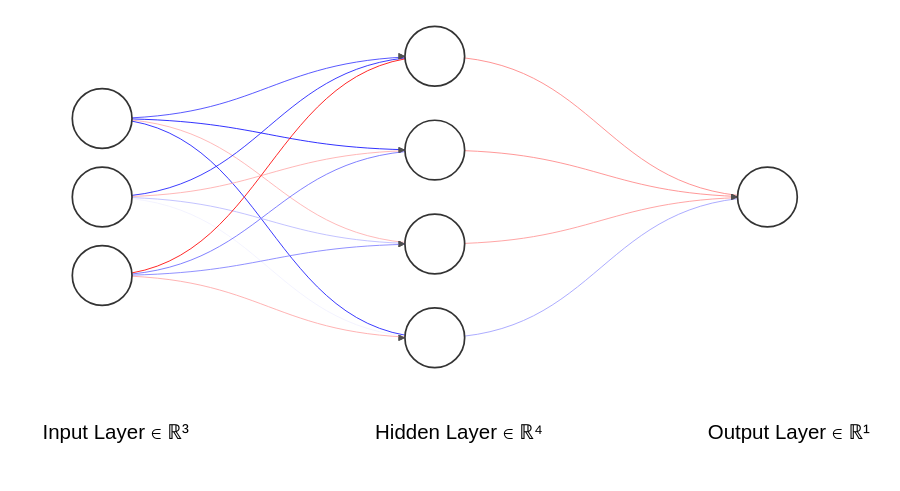

или ещё побольше

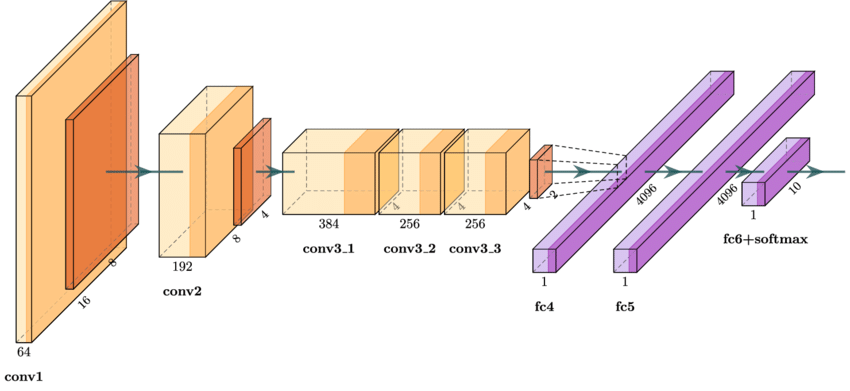

то нам нужно решить две задачи:
- Реализовать много дополнительх строительных блоков
- Сделать наши строительные блоки более универсальными и масштабируемыми

Первый путь их решения - написать каждый модуль вручную в виде совместимых друг с другом классов. Это довольно муторный и неблагодарный путь, который всё равно не позволит достичь достаточной гибкости, необходимой для построения и поддержки действительно больших моделей:

In [31]:
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        
        # Магия инициализации
        pass


    def process_hooks(self):

        # Магия обработки взаимодействия с другими блоками нашей сети
        pass


    def __call__(self, X):

        # Магия обработки взаимодействия с другими блоками нашей сети
        self.process_hooks()

        return self.forward(X)


    def update_weights(self, ):

        # Обновление весов
        pass


    def backward(self):

        # Расчёт градиентов
        return grad
        
    
    def forward(self, X):


        return outp


class Sigmoid:

    # ....

    # ....

    def forward(self):
        pass
    

# и ещё куча подобного кода, который трудно поддерживать и модифицировать


Второй путь - рассмотреть каждый блок нейросети как чёрный ящик.

Устройство этого ящика для нас не важно - важно, чтобы он умел делать следующие вещи:
- Выполнял некоторое преобразование матриц, зависящее от его внутреннего состояния;
- Должен уметь передавать градиент дальше по цепочке;
- Позволяет итерироваться по своим параметрам и подулям
- ...

Раз мы знаем универсальные методы, которые должны быть у нашего строительного блока будет много, можно задействовать классовую абстракцию:


In [32]:
# Псевдокод класса nn.Module и его наследников

from abc import ABC, abstractmethod


class Module(ABC):

    def __init__(self):

        pass

    @abstractmethod
    def forward() -> torch.Tensor:

        pass

    
    def backward() -> torch.Tensor:

        return
    
    # и прочее ...
    
    
class Linear(Module):

    def __init__(self):

        pass


    def forward(self):

        pass




Модуль torch.nn предоставляет большой набор готовых модулей и других рутин, очень малую часть которых мы рассмотрели выше. 

Их описания всегда можно прочитать здесь: https://pytorch.org/docs/stable/nn.html

А исходный код - здесь: https://github.com/pytorch/pytorch/tree/main/torch/nn

Самый важный класс этого модуля - `torch.nn.Module()`. Это намного более продуманная реализация нашего "черного ящика" для элементарного блока нейросети. Все строительные блоки в PyTorch являются наследниками этого класса, и мы напишем несколько своих.

Перечислим некоторые полезные методы, определяемые этим классом:
- `__call__()` - стандартный метод для применения модуля к каким-либо данным. На самом деле реализуется не через magic-метод, но для нас это не особо важно.
- `apply()` - рекурсивно применить функцию к модулю и всем его подмодулям. 
- `to()` - 
- `eval()`, `train()` - переключают режимы работы модуля(позже разберём подробнее);
- `device()`, `cpu()`, `cuda()`, `ipu()`, `xpu()`, `mtia()` - перемещение модуля между платформами;
- `load_state_dict()` - загружает состояние модели;
- `state_dict()` - возвращает (или записывает в файл) словарь, описывающий состояния модуля (и подмодулей);
- `children()` - возвращает итератор по всем _непосредственным_ дочерним модулям;
- `modules()` - возвращает итератор по всем подмодулям;
- `parameters()` - возвращает итератор по всем параметрам всех подмодулей;
- `zero_grad()` - обнуляет градиенты всех параметров;
- `compile()` - компилирует forward метод этого модуля в машинный код с помощью `torch.compile`

Прелесть `pytorch` в том, что единственное, что нужно определить в модуле нейросети, чтобы он начал работать - инициализацию параметров и функцию `forward`

Таким образом, единственное, что нужно определить, чтобы наш  модуль нейросети начал работать - написать инциализацию параметров и само преобразование, выполняемое модулем.

И конечно, сами нейросети на `pytorch` тоже являются наследниками `nn.Module`.

Широкий функционал класса `Module` строится, в том числе, на двух новых базовых классах для хранения параметров. Все они являются подклассами класса `Tensor` и расширяют его функционал.

Класс `Parameter`: это класс, хранящий веса или любые другие параметры модуля. Такие веса будут обновляться на каждом шаге градиентного спуска.

Класс `Buffer`: это специальный класс, который полезен для хранения данных внутри модуля. Записанные в него данные не будут считаться весами и не будут обновляться на обратном проходе (если вы не напишете этот функционал вручную). Например, такие параметры используются в BatchNorm слоях для хранения средних значений.

Аналогичного поведения можно добиться от тензоров с помощью встроенного метода `nn.Module.register_buffer()`.


In [33]:
## Пример:

tensor_a = torch.randn((3, 4, 5))

param_a = nn.Parameter(tensor_a)
print(param_a)


buffer_a = nn.Parameter(tensor_a)
print(buffer_a)

Parameter containing:
tensor([[[ 0.0768,  1.0728, -1.8389,  1.1556,  0.1879],
         [ 0.3346,  1.3096, -0.8834,  0.5647, -0.6030],
         [-0.7645, -0.6849,  1.2295, -1.2149, -0.5912],
         [-0.3222, -0.3882, -0.0862, -0.9923, -2.5334]],

        [[ 0.5907,  0.2228, -0.3325, -0.0817, -1.0990],
         [ 2.0751, -0.9314,  0.3041,  0.6044, -1.5391],
         [-0.0176, -1.1238, -0.3666, -1.1800,  0.9260],
         [ 0.5575, -0.8145,  1.0348,  0.6438, -0.4714]],

        [[-1.1988,  0.4668, -0.7405,  0.6583,  0.0475],
         [ 0.9595, -0.0790, -1.0622, -1.2272,  0.3048],
         [-1.4833,  1.2930, -0.5756,  0.5489, -1.0133],
         [-0.9290,  1.1314, -0.4662,  1.9325, -0.1845]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.0768,  1.0728, -1.8389,  1.1556,  0.1879],
         [ 0.3346,  1.3096, -0.8834,  0.5647, -0.6030],
         [-0.7645, -0.6849,  1.2295, -1.2149, -0.5912],
         [-0.3222, -0.3882, -0.0862, -0.9923, -2.5334]],

        [[ 0.5907,  0.2228, -0.3

In [34]:
## Задача: реализуйте полносвязный блок

class my_Linear(nn.Module):

    def __init__(self, in_features, out_features, bias=True):

        super().__init__()

        # YOUR CODE
        self.w = nn.Parameter(\
            torch.randn((in_features, out_features))
            )
        
        if bias == True:
            self.bias = nn.Parameter(\
                torch.randn((out_features))
                )
            self.forward = self._forward_biased_
        else:
            self.bias = None
            self.forward = self._forward_

        pass


    # YOUR CODE

    def _forward_(self, X) -> torch.Tensor:

        # YOUR CODE
        outp = X @ self.w

        return outp


    def _forward_biased_(self, X) -> torch.Tensor:

        # YOUR CODE
        outp = X @ self.w + self.bias

        return outp


In [35]:
## Задача: создайте свою функцию активации

class my_Sigmoid(nn.Module):

    def __init__(self):

        super().__init__()
        # YOUR CODE
        # nothing required
        pass
        

    def forward(self, X) -> torch.Tensor:

        # YOUR CODE
        outp = 1/(1 + torch.exp(-X))
        
        return outp
    

In [36]:
# Протестируем с помощью модуля Unittest:
import unittest

class TestLayers(unittest.TestCase):

    def setUp(self):

        self.linear_constructor = my_Linear
        self.activation_constructor = my_Sigmoid


    def test_Linear(self):

        test_cases = [\
            {'in': 1, 'out':1, 'bias': True},
            {'in': 10, 'out':5, 'bias': False},
            {'in': 100, 'out':10, 'bias': True}
        ]
        batch_size = 1

        for tst in test_cases:

            L1 = self.linear_constructor(
                in_features=tst['in'],
                out_features=tst['out'],
                bias=tst['bias']
                )
            
            if tst['bias']:

                test_inp = torch.randn((batch_size, tst['in']))
                
                exp_shape = torch.zeros((batch_size, tst['out'])).shape

                outp = L1(test_inp)

                self.assertTrue(
                    outp.shape == exp_shape,
                    'Output shape {} does not match expected {}'.format(outp.shape, exp_shape))
                
                self.assertTrue(
                    outp.requires_grad,
                    'Gradients are not attached to output')
   
            else:

                test_inp = torch.zeros((batch_size, tst['in']))
                
                exp_out = torch.zeros((batch_size, tst['out']))

                outp = L1(test_inp)

                self.assertFalse(
                    outp.shape == exp_shape,
                    'Output shape {} does not match expected {}'.format(outp.shape, exp_out.shape))

                self.assertTrue(
                    torch.allclose(outp, exp_out, atol=1e-3, rtol=1e-3),
                    'Without bias, only zeros should be on output')
                
                self.assertTrue(
                    outp.requires_grad,
                    'Gradients are not attached to output')
   
    
    def test_Activation(self):

        test_cases = [\
            {'in': (1)},
            {'in': (10)},
            {'in': (10, 10)}
            ]

        S1 = self.activation_constructor()
        S2 = nn.Sigmoid()

        for tst in test_cases:

            test_inp = torch.randn(tst['in'])

            outp_1 = S1(test_inp)
            outp_2 = S2(test_inp)

            self.assertTrue(\
                torch.allclose(outp_1, outp_2, rtol=1e-3,atol=1e-3),
                'Output mismatch with built-in pytorch Sigmoid'
                )

        

unittest.main(argv=[''], verbosity=2, exit=False)

test_Activation (__main__.TestLayers.test_Activation) ... ok
test_Linear (__main__.TestLayers.test_Linear) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


In [37]:
## Пройдёмся по части перечисленного функционала и убедимся,
## что наши модули унаследовали атрибуты и методы nn.Module()

model_a = nn.Sequential(\
    my_Linear(1, 1),
    my_Sigmoid()
)

print("Modules:")

for module in model_a.modules():
    print('--------')
    print(module)
    print(module.state_dict())
print('========\n')

print(model_a.state_dict())

Modules:
--------
Sequential(
  (0): my_Linear()
  (1): my_Sigmoid()
)
OrderedDict({'0.w': tensor([[1.0897]]), '0.bias': tensor([0.6214])})
--------
my_Linear()
OrderedDict({'w': tensor([[1.0897]]), 'bias': tensor([0.6214])})
--------
my_Sigmoid()
OrderedDict()

OrderedDict({'0.w': tensor([[1.0897]]), '0.bias': tensor([0.6214])})


Из готовых блоков, на данном этапе нам будут полезны:

- nn.Linear
- nn.Sigmoid, nn.Tanh, nn.Relu и другие активации

Модуль `torch.nn`, кроме прочего, определяет множество функций ошибки.

Благодаря магии автоматического дифференцирования, функцию ошибки достаточно просто определить - как обычный метод или лямбда-выражение:

In [38]:
my_MSE = lambda Y, Y_p: sum((Y-Y_p)**2)

X_prob = torch.randn((10, 1))
y_prob = torch.randn((10, 1))
y_pred = model_a(X_prob)

loss = my_MSE(y_pred, y_prob)
print(loss)

loss.backward()

tensor([13.6413], grad_fn=<AddBackward0>)


# Модуль `torch.optim`

Теперь рассмотрим процесс оптимизации как чёрный ящик... ну, вы понимаете, к чему мы идём.

Все процедуры, применяемые при обучении сети методом стохастического градиентного спуска, могут и должны быть обобщены. Это первоклассно реализовано в модуле `torch.optim`.

Подробно разбирать этот модуль не будем, только рассмотрим минимальный пример оптимизатора на нашей задаче о градуснике:

In [39]:
from torch.optim import Optimizer


class CustomGradientDescent(Optimizer):

    def __init__(self, params, lr=0.01):
        

        defaults = {'lr': lr}
        super(CustomGradientDescent, self).__init__(params, defaults)


    def step(self, closure=None):
        '''
        Шаг оптимизации.
        '''
        
        # if closure is not None:
        #     closure()

        for group in self.param_groups:
            lr = group['lr']
            for param in group['params']:

                # Если градиента нет, пропускаем
                if param.grad is None:
                    continue

                # В остальных случаях делаем шаг градиентного спуска
                param.data = param.data - lr * param.grad.data


In [40]:
## Создадим модель на основе наших классов и применим к ней:

class ThermometerModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.L1 = my_Linear(1,1)


    def forward(self, X):

        outp = self.L1(X)

        return outp


model = ThermometerModel()

# Определим функцию ошибки

criterion = torch.nn.MSELoss()

# Подготовим данные
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).view(-1, 1)
t_u = torch.tensor(t_u).view(-1, 1)



# Создадим оптимизатор
optimizer = CustomGradientDescent(model.parameters(), lr=1e-4)

# Цикл обучения:
for epoch in range(100):
    
    # Переводим модель в режим обучения
    model.train()

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Прямое распространениеa
    t_pred = model(t_u)
    
    # Считаем ошибку и делаем обратное распространение
    loss = criterion(t_pred, t_c)  
    loss.backward()      

    # Обновляем веса
    optimizer.step()

    # Выводим ошибку на эпохе:
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 3029.53515625
Epoch 10, Loss: 32.54353332519531
Epoch 20, Loss: 32.53310012817383
Epoch 30, Loss: 32.52273941040039


Epoch 40, Loss: 32.51237106323242
Epoch 50, Loss: 32.50201416015625
Epoch 60, Loss: 32.49165725708008
Epoch 70, Loss: 32.481300354003906
Epoch 80, Loss: 32.4709587097168
Epoch 90, Loss: 32.46061706542969


# Задача: предсказание чисел Вольфа

Числа Вольфа - это качественный показатель солнечной активности, связанный с количеством солнечных пятен. 

Официально числа Вольфа регистрируются Цюрихской обсерваторией с 1849 года, но восстанавливают и более ранние данные - в нашем случае отсчёт будет идти с 1818 года.

Наша задача - научить полносвязную нейросеть предсказывать этот _временной ряд_.

Напомню, что временной ряд - это последовательность точек данных (в данном случае - количества пятен на Солнце), разделённая равными временными интервалами.

Одна из стандартных методик предсказания временных рядов - экстраполяция, т.е. предсказание следующих данных на основе предыдущих.

В случае нейросетей методика следующая:
- Задают размер окна данных, на основе которого делается предсказание;
- Нейросеть учится на всех возможных окнах несколько эпох;
- Профит!


In [2]:
## Задание 1: Загрузите и изучите данные

data_path = root_path + '/data/ISSN_D_tot.csv'

# Filename: ISSN_D_tot.csv
# Contents:
# Column 1-3: Gregorian calendar date
# - Year
# - Month
# - Day
# Column 4: Date in fraction of year
# Column 3: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value).
# Column 4: Definitive/provisional indicator. '1' indicates that the value is definitive. '0' indicates that the value is still provisional and is subj


# YOUR CODE
sol_df = pd.read_csv(data_path,header=0)

print(sol_df.info())
print(sol_df.isna().sum())

print(sol_df.sample(10))

# Нам понадобится только колонка "VAL"

data = sol_df['VAL'].to_numpy()
print(type(data))
data = torch.FloatTensor(data)
print(type(data), data.dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72104 entries, 0 to 72103
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YYYY    72104 non-null  int64  
 1   MM      72104 non-null  int64  
 2   DD      72104 non-null  int64  
 3   YEARF   72104 non-null  float64
 4   VAL     72104 non-null  int64  
 5   I       72104 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 3.3 MB
None
YYYY     0
MM       0
DD       0
YEARF    0
VAL      0
I        0
dtype: int64
       YYYY  MM  DD     YEARF  VAL  I
69465  2008   3  10  2008.189    9  1
33061  1908   7   9  1908.520   30  1
44825  1940   9  23  1940.728   66  1
42370  1934   1   3  1934.007    0  1
29526  1898  11   3  1898.842   60  1
51139  1958   1   6  1958.015  192  1
36416  1917   9  15  1917.706   99  1
23984  1883   9   1  1883.669   92  1
29837  1899   9  10  1899.693    0  1
14960  1858  12  17  1858.962  114  1
<class 'numpy.ndarray'>
<class 'torch.Tensor

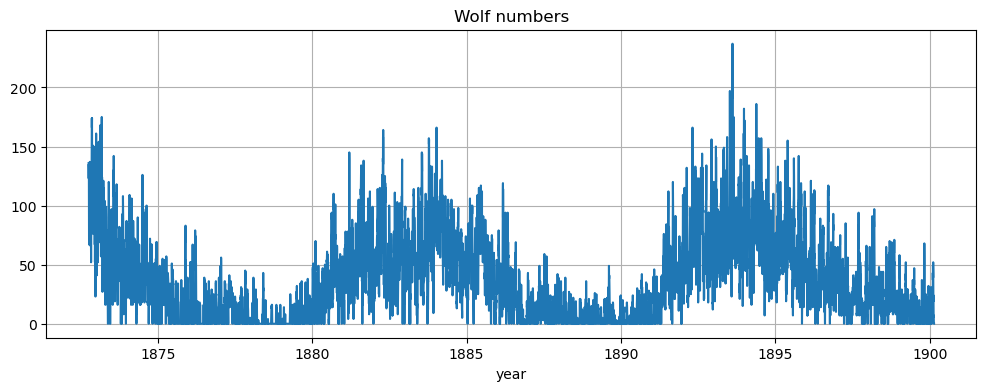

In [ ]:
start = 20000
scope = 10000

plt_val = sol_df['VAL'][start:start+scope]
plt_t = sol_df['YEARF'][start:start+scope]

fig, ax1 = plt.subplots(1,1,figsize=(12,4))
ax1.plot(plt_t, plt_val)
ax1.grid('on')
ax1.set_title('Wolf numbers')
ax1.set_xlabel('year')

plt.show()

In [9]:
# Задание 2: Напишите класс TimeseriesLoader
# для создания генераторов пар (x_window, y_pred)
# На основе наших данных

class TimeseriesLoader():

    def __init__(self, data: torch.Tensor, lookback, fwd_scope=1, stride=1):


        # YOUR CODE
        self.N_points = data.shape[0]
        self.data = data

        self.lookback = lookback # Число прошлых точек данных, которые используем для предсказания
        self.fwd_points = fwd_scope
        self.stride = stride        

        return None


    def __iter__(self):

        # YOUR CODE
        self.N0 = 0
        self.N1 = self.lookback
        self.N2 = self.lookback + self.fwd_points

        stride = self.stride

        self.next_id = lambda N0, N1, N2 : (N0 + stride, N1 + stride, N2 + stride)
        self.last_N = self.N_points - self.fwd_points

        return self


    def __next__(self):

        # YOUR CODE
        if self.N2 < self.N_points:
            x = self.data[self.N0:self.N1]
            y = self.data[self.N1:self.N2]

            self.N0, self.N1, self.N2 = self.next_id(self.N0, self.N1, self.N2)

            return (x, y)

        else:
            raise StopIteration


## Тестируем:
A = torch.randn((8, 2))

loader = TimeseriesLoader(A, 2, 2, 1)

for d in loader:
    print(d)



(tensor([[ 1.0787, -0.7725],
        [-0.2582,  0.5558]]), tensor([[ 1.4523,  1.9204],
        [-0.5573, -0.5893]]))
(tensor([[-0.2582,  0.5558],
        [ 1.4523,  1.9204]]), tensor([[-0.5573, -0.5893],
        [-0.7130,  1.6038]]))
(tensor([[ 1.4523,  1.9204],
        [-0.5573, -0.5893]]), tensor([[-0.7130,  1.6038],
        [ 0.5695,  0.1595]]))
(tensor([[-0.5573, -0.5893],
        [-0.7130,  1.6038]]), tensor([[ 0.5695,  0.1595],
        [-1.5151, -0.8032]]))


In [60]:
from impls.utils import StandardScaler
scaler = StandardScaler()

scaler.fit(data)
data = scaler.transform(data)

In [61]:
# Сгенерируeм наборы окон из данных с помощью TimeseriesLoader()

LOOKBACK = 60
FWD_SCOPE = 1

split_point = 64000

data_train = data[:split_point]
data_val = data[split_point:]

train_loader = TimeseriesLoader(data_train, lookback=LOOKBACK, fwd_scope = FWD_SCOPE, stride=FWD_SCOPE)
val_loader = TimeseriesLoader(data_val, lookback=LOOKBACK, fwd_scope = FWD_SCOPE, stride=FWD_SCOPE)

train_frames = [frame for frame in train_loader]
val_frames = [frame for frame in val_loader]

X_train = torch.stack([frame[0] for frame in train_frames])
y_train = torch.stack([frame[1] for frame in train_frames])

X_val = torch.stack([frame[0] for frame in val_frames])
y_val = torch.stack([frame[1] for frame in val_frames])

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

torch.Size([63939, 60])
torch.Size([63939, 1])
torch.Size([8043, 60])
torch.Size([8043, 1])


In [52]:
## Задание 3: Напишите класс модели.
## Реализуйте методы __init__ и forward

# YOUR CODE
class SeriesPredictor(nn.Module):

    def __init__(self, lookback, scope):

        heads = 20
        super().__init__()
        self.L1 = nn.Linear(in_features=lookback, out_features=scope*heads)
        self.A1 = nn.Sigmoid()
        self.L2 = nn.Linear(in_features=scope*heads, out_features=scope)
        # self.A2 = nn.ReLU()


    def forward(self, X):

        X1 = self.A1(self.L1(X))
        outp = self.L2(X1)
        # X2 = self.A2(self.L2(X1))
        # outp = self.L3(X2)

        return outp


## Тестируем:

lookback = 4
scope = 5
batch_size = 2

X_try = torch.randn(batch_size, lookback)
y_try = torch.randn(batch_size, scope)

model_P = SeriesPredictor(lookback=lookback, scope=scope)

# Если всё нормально, у предсказанного тензора будет градиент,
# а сам он будет иметь форму [batch_size, scope]
y_pred = model_P.forward(X_try)
print(y_pred)
print(y_pred.shape)
loss = nn.MSELoss()

print(loss(y_pred, y_try))



tensor([[ 0.1213,  0.0490, -0.4970, -0.3469,  0.0587],
        [ 0.1119,  0.0749, -0.4158, -0.3383,  0.0789]],
       grad_fn=<AddmmBackward0>)
torch.Size([2, 5])
tensor(1.2339, grad_fn=<MseLossBackward0>)


In [ ]:
## Задание 4: реализуйте train_loop и обучите модель

def progress(model, loss_h, val, epoch, n_epochs):

    pass
# Train loop:


def train_loop(model, loss, sampler, val, optimizer, n_epochs=30):
    
    # YOUR CODE
    loss_history = []
    
    y_eval = model.forward(sampler.X_train)
    loss_history.append(loss(y_eval, sampler.y_train))

    for epoch in range(n_epochs):

        batches = sampler.sample()

        for (x_b, y_b) in batches:

            model.train()
            optimizer.zero_grad()

            y_pred = model.forward(x_b)

            loss_val = loss(y_pred, y_b)
            loss_val.backward()

            optimizer.step()


        with torch.no_grad():

            X_val, y_val = val
            y_pred = model.forward(X_val)
            loss_val = loss(y_pred, y_val)
            loss_history.append(loss_val)

            print(f'Epoch {epoch}, Loss: {loss_val.item()}')


# Все вызовы для обучения:
from impls.utils import BatchSampler

# YOUR CODE
batch_size = 50
n_batches = 500

sampler = BatchSampler(X_train, y_train, batch_size=batch_size, n_batches=n_batches)

model = SeriesPredictor(lookback=LOOKBACK, scope=FWD_SCOPE)
# model.compile()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_loop(model=model,
        loss=loss,
        sampler=sampler,
        val = (X_val, y_val),
        optimizer=optimizer,
        n_epochs=20)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

# train_loop(model=model,
#         loss=loss,
#         sampler=sampler,
#         val = (X_val, y_val),
#         optimizer=optimizer,
#         n_epochs=20)



Epoch 0, Loss: 0.12128274142742157
Epoch 1, Loss: 0.0789375826716423
Epoch 2, Loss: 0.06357411295175552
Epoch 3, Loss: 0.055688656866550446
Epoch 4, Loss: 0.05159258097410202
Epoch 5, Loss: 0.04903135448694229
Epoch 6, Loss: 0.04803527146577835
Epoch 7, Loss: 0.04740162566304207
Epoch 8, Loss: 0.04521678388118744
Epoch 9, Loss: 0.04369885101914406
Epoch 10, Loss: 0.04482835903763771
Epoch 11, Loss: 0.04550926014780998
Epoch 12, Loss: 0.04331936314702034
Epoch 13, Loss: 0.04277382045984268
Epoch 14, Loss: 0.04299835488200188
Epoch 15, Loss: 0.042193714529275894
Epoch 16, Loss: 0.042138129472732544
Epoch 17, Loss: 0.042194705456495285
Epoch 18, Loss: 0.043219391256570816
Epoch 19, Loss: 0.043018925935029984
Epoch 0, Loss: 0.042721446603536606
Epoch 1, Loss: 0.04255000874400139
Epoch 2, Loss: 0.04246145486831665
Epoch 3, Loss: 0.042588673532009125
Epoch 4, Loss: 0.042503394186496735
Epoch 5, Loss: 0.042632054537534714
Epoch 6, Loss: 0.04263303056359291
Epoch 7, Loss: 0.04241444915533066
E

torch.Size([8043, 1])


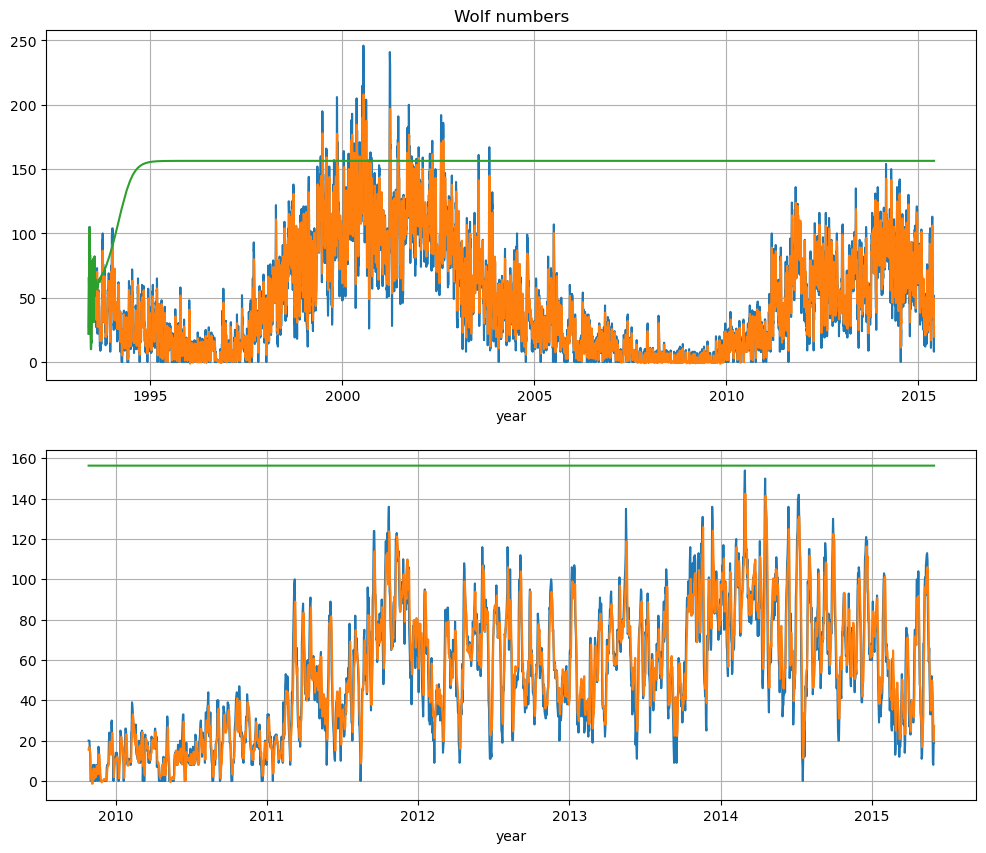

In [74]:

plt_t = sol_df['YEARF'][split_point+LOOKBACK+1:]

time = len(plt_t)

with torch.no_grad():
    y_pred=model(X_val)

y_seq = torch.zeros_like(y_val)
y_seq[0:LOOKBACK, :] = y_val[0:LOOKBACK, :]
print(y_seq.shape)

with torch.no_grad():
    for t in range(0, time-LOOKBACK-1):
        y_seq[t+LOOKBACK+1, 0] = model(y_seq[t:t+LOOKBACK, 0])

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))


ys_val = scaler.inverse(y_val[:, 0])
ys_pred = scaler.inverse(y_pred[:, 0])
ys_seq = scaler.inverse(y_seq[:, 0])

t2 = 6000

ax1.plot(plt_t, ys_val)
ax1.plot(plt_t, ys_pred)
ax1.plot(plt_t, ys_seq)
ax1.grid('on')
ax1.set_title('Wolf numbers')
ax1.set_xlabel('year')

ax2.plot(plt_t[t2:], ys_val[t2:])
ax2.plot(plt_t[t2:], ys_pred[t2:])
ax2.plot(plt_t[t2:], ys_seq[t2:])
ax2.grid('on')
ax2.set_xlabel('year')

plt.show()